# Multimodality & Different Samplers
When using NumPyro, you'll find HMC to be a great general purpose tool in most cases. It self-tunes to adapt to correlated or non-gaussian geometry, has good scaling with dimensionality and converges quickly thanks to its rapid burn-in. Aside from cost concerns, HMC falls short in one main area: it almost completely falls over when pitched against a multimodal distribution. Here, I demonstrate the sort of issues HMC faces when the posterior isn't smooth and unimodal, and use this as a lense to introduce and examine a few of NumPyro's other samplers.

**Index**  
- [Simple Multimodal Distributions](#simpledist)  
  - [Hamiltonian Monte Carlo](#HMC01)
  - [Barker Metropolist-Hastings](#BMH01)
  - [Sample Adaptive](#SAC01)
  - [Nested Sampling](#NS01)
- [Rough / Aliased Posteriors](#roughdist)  
  - [Hamiltonian Monte Carlo](#HMC02)
  - [Barker Metropolist-Hastings & Sample Adaptive](#BMH02)
  - [Nested Sampling](#NS02)

-----

In [1]:
import jax, numpyro, jaxopt
import jax.numpy as jnp
from numpyro import infer, distributions

import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt

/home/hughmc/anaconda3/envs/nestconda_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simple Multimodal Distributions <a id='simpledist'></a>

In this section, we'll examine a simple case of multimodality, a 2D distribution with unequal, well-spaced modes with a posterior that is in every other way "well behaved", i.e. the modes are gaussian and the space between them smooth. Our 2D posterior consist of four gaussian 'islands' of probability, with one of them of a lower height / peak likelihood. Rather than go through the hassle of making an actual gaussian mixture model, I've just hacked this together with a JAX-friendly potential function run through `numpyro.factor`, which lets us add an arbitrary term to $ln \lvert \mathcal{L} \rvert$:

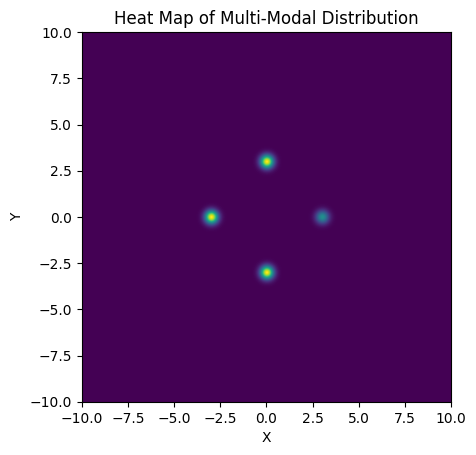

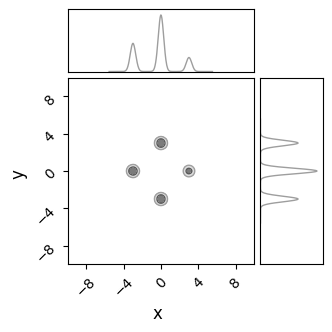

In [73]:
width, spacing = 0.25, 3.0 # Width / dist from center of gaussian modes

# Prior Volume
xmin, xmax = -10, 10
ymin, ymax = -10,10

#----------------------------

def potential(x,y):
    '''Multimodal potential function'''
    out=0
    
    # Likelihood Modes
    out+=jnp.exp(-1/2* (jnp.power((x - spacing),2) + jnp.power(y,2)) / width**2) * 0.5 # Mode on right, half as high
    out+=jnp.exp(-1/2* (jnp.power((x + spacing),2) + jnp.power(y,2))/ width**2)        # Left mode
    out+=jnp.exp(-1/2* (jnp.power(x, 2)   + jnp.power(y-spacing,2))/ width**2)         # Top mode 
    out+=jnp.exp(-1/2* (jnp.power(x, 2)   + jnp.power(y+spacing,2))/ width**2)         # Bottom mode
    
    return(out)
     
def model():
    '''NumPyro Model'''
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))

    # Extra 1E-15 term required because samplers can break when the potential gets too close to zero
    numpyro.factor('potfunc',jnp.log(potential(x,y) + 1E-15) )

#------------------------------------------
# Plotting

# Generate a grid of X/Y values
nplot = 1024
xplot, yplot = jnp.linspace(xmin,xmax, nplot), jnp.linspace(ymin,ymax, nplot)
X, Y = jnp.meshgrid(xplot, yplot)

# Use these to construct the potential function
Z = potential(X,Y)
plt.imshow(Z[::-1,::], extent = [xmin, xmax, ymin, ymax]) # Plot heatmap of the distribution
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Heat Map of Multi-Modal Distribution")
plt.show()

C= ChainConsumer()
C.add_chain({'x':X.flatten(), 'y':Y.flatten()}, weights=Z.flatten(), color='grey')
C.plotter.plot(extents = {'x':[xmin,xmax],'y':[ymin,ymax]})
plt.show()

Now, we can test a few of the different samplers available in NumPyro to see how they perform against this multimodal distribution. Something we need to consider is that, unlike unimodal distributions, we need to run many MCMC chains to build up an image of the distribution, for reasons that will become clear in a moment. Every chain needs to end up in one of the modes. If there are $n_{modes}$ modes, then the chance of landing in any one island is $p=1/n_{modes}$. From this, we can estimate how many chains end up in each mode. For $N$ total chains:

\begin{equation}
N_{i} = pN \pm \sqrt{Np(1-p)} \; \; \; \; \;
\frac{N_{i}}{N} = p \pm \frac{1}{\sqrt{N}} \frac{\sqrt{(p (1-p)}}{p}
\end{equation}

If we have $n_{modes}=4$, i.e. $p=\frac{1}{m}$, and want to measure this smallest mode accurately to within  $\Delta \frac{N_{i}}{N} < 10 \%$, we need $\approx 300$ chains. 

### Hamiltonian Monte-Carlo (HMC) / The No U-Turn Sampler (NUTS) <a id='HMC01'></a>

Hamiltonian Monte-Carlo (HMC) is the go-to tool for MCMC in NumPyro, an efficient sampler with good high-dimensional scaling. NumPyro works by "rolling a ball" around a landscape with potential wells at high likelihood, randomizing the direction and kinetic energy of the ball at random intervals. This makes it great in problems with high dimensions and or complicated posteriors, but means that it works poorly when there are multiple modes, as each individual chain can't transit between them and instead becomes pinned at local optima. The closest thing to a valid approach is to just throw many (hundreds) of chains at the board and hope they map the modes properly. As we'll see in a moment, even this is not a proper solution.

**How it Works**  
Like the name suggests, "Hamiltonian" Monte-Carlo invokes Hamiltonian mechanics, modelling the path of the sampler as a kinematic object rolling about the geometry of the posterior. HMC constructs a landscape of "potential energy" $U(\vec{z})$, with high energy at low likelihood and vice versa, and defines a "momentum" $\vec{p}$ related to the speed of the sampler in $z$-space. This forms a full Hamiltonian:

$$
H(\vec{z}, \vec{p}) = KE(\vec{p}) + PE(\vec{z}) = \frac{\vec{p} M^{-1} \vec{p}}{2} -\frac{ln \lvert \pi(\vec{z}) \mathcal{L}(\vec{z}) \rvert}{2}
$$

Notice that the potential energy is something similar to the $\chi^2$ term. The "mass matrix" $M$ improves performance by accounting for correlation and differences in scale and between different variables, but can be removed / set to an identity matrix without fundamentally breaking the algorithm. This hamiltonian is used to evolve the  position / momentum according to hamiltonian mechanics, made possible by JAX's auto-diff functionality:

$$
\frac{d z_i}{dt} = \frac{\partial H}{\partial p_i}, \;\;\;  \frac{d p_i}{dt} = - \frac{\partial H}{\partial z_i}
$$

With the evolution carried out with standard time-series integration like we would use for any physical system, e.g. [leap-frog integration](https://en.wikipedia.org/wiki/Leapfrog_integration). Particles move with fixed total energy for over a trajectory, and then randomize their direction and energy before sampling and proceeding on a new trajectory. Different implementations of HMC are concerned with tuning the step size, trajectory length and mass matrix to particular problems. NumPyro makes use of the No U-Turn Sampler (NUTS), which trims the trajectories when it seems like a path is doubling back on itself and makes use of a multi-stage tuning process during burn-in to estimate the best step size and mass matrix for a given problem.

In [3]:
nchains  = 300
nsamples = 100
nburn    = 200

sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)

print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_HMC=sampler.get_samples()

Starting Sampling...
Sampling Done


Though NUTS does a good job of locating each of the modes with its efficient burn-in, it <i>doesn't</i> succesfully identify their heights. Because the modes are so fully separated, chains stick to whichever mode they first encounter and over-sampling low likelihood modes. Thanks to the symmetry of our simple posterior, chains have a roughly equal chance of ending up in each mode, and so each mode has roughly the same height / number of samples, despite one being lower than the others in the true posterior:

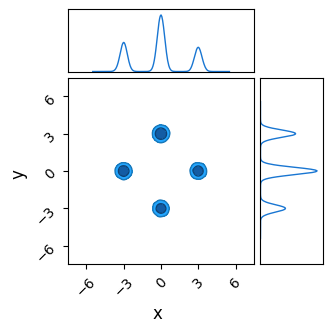

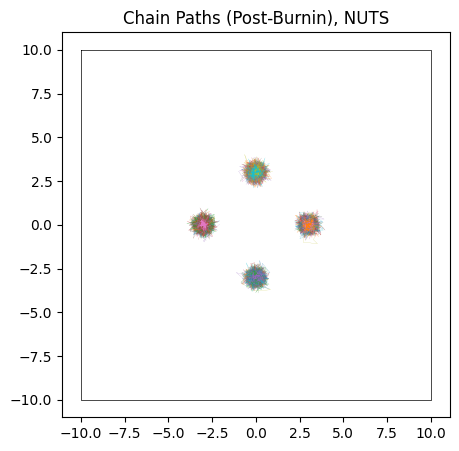

In [4]:
# Save this as a function for repeating later
def do_plot(results, name, do_paths = True, do_contour = True, color = 'blue', scale = 0.75):
    
    c = ChainConsumer()
    #--------------------
    # Chain Consumer plot
    if do_contour:
        if name in [chain.name for chain in c.chains]: c.remove_chain(name)
        c.add_chain([results['x'], results['y']], parameters=['x','y'], name=name, shade_alpha = 1.0, color = color)
        c.plotter.plot(chains=[name], extents = {'x': [xmin * scale, xmax * scale], 'y': [ymin * scale , ymax * scale]})
    
        plt.show()

    #--------------------
    if do_paths:
        plt.figure(figsize=(5,5))
        
        plt.title("Chain Paths (Post-Burnin), %s" %name)
        plt.axis('equal')
        
        plt.plot([xmin,xmax,xmax,xmin,xmin], [ymax,ymax,ymin,ymin,ymax],c='k',lw=0.5)
        plt.errorbar( [-spacing,0,0,spacing], [0,-spacing,spacing,0], xerr=width, yerr=width,c='r',fmt='none')
        plt.xlim(xmin,xmax)
        plt.xlim(ymin,ymax)
        
        #Plot Chains
        for i in range(nchains):
            plt.plot(results['x'][i*nsamples:(i+1)*nsamples], results['y'][i*nsamples:(i+1)*nsamples], lw=0.1)
        plt.show()

#============================
do_plot(output_HMC, "NUTS")

**Pros & cons**  
HMC and NUTS use of fancy gradient-based algorithms make them the best choice for any high dimensional problem, and their complicated self-tuning burn-in process makes them a good choice even in low dimensional models. In most cases, you can afford to use HMC as a first pass unless you know a-priori that there's significant issues with multimodality.

<ins>The Good</ins>
- _Very_ good scaling with dimension: the best of any current method
- Converges _fast_, burn-in is super efficient as the use of gradients lets the walker rapidly track towards modes 
- Automatic tuning makes it a (mostly) reliable "out of the box" tool for complicated posteriors without manual tuning
- Uses internal coordinate transformations to handle correlated contours (see discussion of the [mass matrix](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html) in HMC)
- Can handle unusual shapes and curved contours without distorting your results

<ins>The Bad</ins>
- JAX makes evaluating gradients _cheaper_, but not free. The cost of each evaluation in HMC will always be higher than a non-gradient method
- Uses multiple evaluations per sample, and it's not always obvious how many. In bad cases, sampling can slow to a crawl so the integrator can handle complicated geometry
- Can get expensive for complex geometry as the step size is reduced and the automatic tuning becomes difficult.
- Cannot handle multimodal distributions at all, as chains can't migrate between modes
- Has trouble navigating in "rough" geometry, e.g. sharp walls of low potential (like we often see in aliasing problems)

### Barker Metropolis-Hastings <a id='BMH01'></a>

An alternative to HMC that still leverages JAX's autodiff is Barker Metropolis-Hastings (BMH). This method works by using a normal Metropolis Hastings-type proposal, but uses the gradient to skew and offset the distribution such that it is weighted to travel "uphill" more efficiently. BMH doesn't scale as well as HMC (its efficacy decays with $d^{-\frac{1}{3}}$ rather than HMC's $d^{-\frac{1}{4}}$), but the more stochastic nature makes it better at escaping small local optima.

**How it Works**  
BMH follows a variant of the normal metropolis hastings algorithm, but using a correction factor $p(z)$ that skews the proposal towards higher likelihoods.
- When at postion $z$, calculate the value $\mathcal{L}(z)$ and gradient $\nabla \mathcal{L}(z)$ of the likelihood function
- Generate an incremental step, $\Delta z$ from a typical MH proposal $Q(\Delta z)$, e.g. from a normal distribution
- Calculate the gradient correction factor $p(z,\Delta z) = (1+\text{exp}(\Delta z \cdot \nabla \mathcal{L}))^{-1}$
- Make the update $z \rightarrow z + \Delta z$ with probability $p(z,\Delta z)$, or $z \rightarrow z - \Delta z$ with probability $1 - p(z,\Delta z)$

This yields a distribution that converges to a normal distribution at low gradients, but becomes biased towards moving uphill as the gradient increases. Another handy feature of the barker proposal is that it gets more compact as the gradient gets sharper, meaning it encourages small cautious updates in regions of rapid change.

<center>
<img src="Livington_Zanella_2020_01.png" align="center"/> <br>
<b>Example of 1D and 2D barker proposal contours from <a href="https://arxiv.org/abs/1908.11812" target="_blank">Livingson & Zanella, 2020</a></b>
</center>


In [5]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.BarkerMH (model),
    num_warmup  = 300,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_BMH =sampler.get_samples()

Starting Sampling...
Sampling Done


Overall, BMH has little to distinguish its results from HMC in most cases. Because it uses gradients in a more stochastic sense than HMC, its burn-in isn't quite as efficient, with our toy example here needing $\approx 300$ burn-in steps per chain to HMC's $\approx 200$. Because it shares HMC's chain-by-chain gradient based sampling, where each proposal only "knows" about its local environment, BMH falls victim to the same 'evening out' of the modes in multimodal distributions.

Note that BMH still uses a "mass mastrix" to estimate the covariance of the distribution for more efficient proposals, using the same naming convention as HMC even in the absence of the phyiscal analogue.

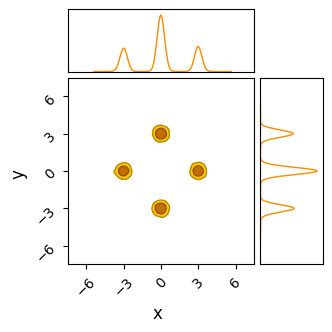

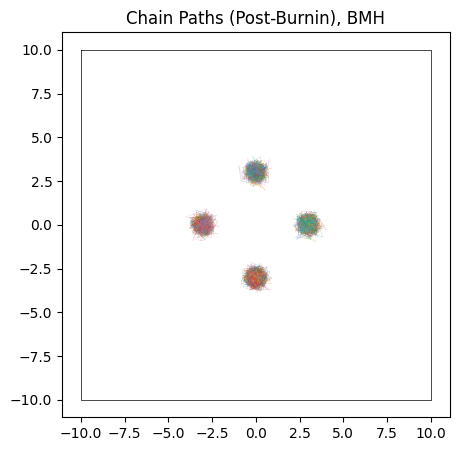

In [6]:
do_plot(output_BMH, "BMH", color = 'orange')

**Pros & cons**  

<ins>The Good</ins>
- Good dimensionality scaling: goes like $d^{1/3}$
- One and only one evaluation for every sample: easier to determine run-time a-priori
- Stochastic "jumping" allows it to jump small gaps between modes
- Uses internal coordinate transformations (see discussion of the [mass matrix](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html) in HMC) to handle correlated datasets

<ins>The Bad</ins>
- Requires evaluating gradients, which can get expensive
- Dimensionality scaling isn't _quite_ as good as HMC
- Fails in multi-modal distributions: can't jump between modes
- Warm-up can (optionally) involve tuning a mass matrix, which can get expensive for non-linear correlations

### Sample Adaptive Sampler <a id='SA01'></a>

Though NUTS and BMH achieve their good performance from JAX's automatic differentiation, there are cases where we might want to use a simpler 'gradient free' method. To this end, NumPyro offers the Sample Adaptive (SA) sampler, a cheaper and less complicated sampling algorithm. Though SA's simpler approach is much less efficient and scales worse in high dimensions, it is markedly cheaper in each evaluation, and has less 'moving parts' that can fail in edge cases.

**How it Works**  
The [Sample-Adaptive Sampler](https://proceedings.neurips.cc/paper_files/paper/2019/file/2cfa8f9e50e0f510ede9d12338a5f564-Paper.pdf) operates by tracking an ensemble of points in parameter space and approximating them as following a gaussian bubble. In this way, it's similar to the classic metropolis hastings algorithm, but wih a self-tuning proposal distribution.  

The procedure is to, at each itteration:
- Define a multivariate gaussian, $g(\theta)$, based on the mean and covaraince of the current ensemble of $N$ samples
- Draw a new sample from this distribution and calculate its likelihood, $\mathcal{L}(\theta_{N+1})$
- For each sample $\theta_{i}$ in the ensemble (including the new point, $i \in [1,N+1]$):
  - Replace that sample $\theta_{i}$ with the new proposal sample $\theta_{N+1}$
    - Re-calculate a multivariate gaussian based on the mean and covariance of this ensemble, $g_{i}(\theta)$
    - Calculate $\lambda_i = g_{i}(\theta_i) / \mathcal{L}(\theta_i)$
- Randomly select one of these sub-ensembles to proceed with, using probability proportional to $\lambda_i$ 

In [7]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.SA(model),
    num_warmup  = 2000,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_SA=sampler.get_samples()

Starting Sampling...
Sampling Done


Unlike NUTS, in which each chain sticks to the first mode it finds, SA's less sophisticated pathfinding lets is hop between islands. For the same number of chains and samples, SA does a better job of recovering the true distribution, but at the cost of being much less efficient and requiring a _significantly_ longer burn-in time. In this example I've used a burn-in of $\approx 1000$ steps, 10 times more than HMC.

Even with this long burn-in time, SA has not fully converged: the contours it produces are too wide, and we can see from their paths that some of the chains need more time to close in on the 'islands'. This is on top of the proposal distribution "stretching across" multiple modes, meaning a large number of samples are proposed _between_ the modes, giving a terrible acceptance ratio in these cases.

If given enough time (another order of magnitude), SA does, eventually, converge to the true distribution. Because its proposal method allows chains to migrate between modes, they eventually adjust into their correct size by sheer brute force. When absolutely nothing else works and computation is cheap, SA offers an inelegant but general solution.

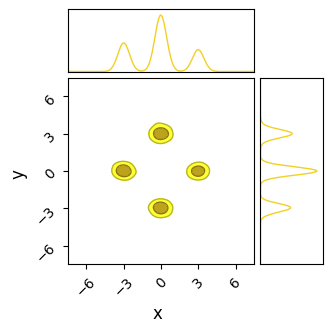

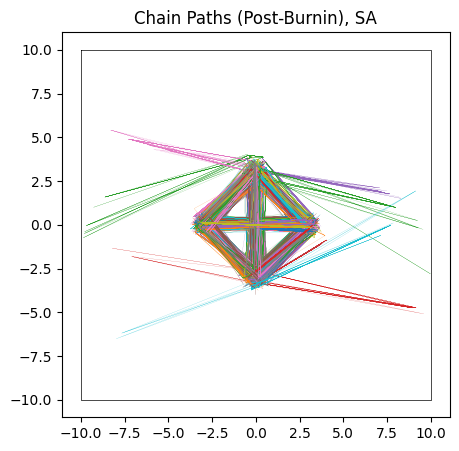

In [8]:
do_plot(output_SA, "SA", color='yellow', do_paths = True)

**Pros & cons**  

<ins>The Good</ins>
- Low cost per itteration: don't need to evaluate gradients
- Ensemble based sampling means that samples can jump between modes, helping to deal with multimodality
- Metropolis-Hastings proposals allow escape from local optima
- One evaluation per sample, known time-cost of running a chain

<ins>The Bad</ins>
- Poor scaling with dimension
- High sample rejection rate
- Doesn't deal with multimodality perfectly, suffers from extremely high rejection rate in these cases
- _Very_ long burn-in times

### Nested Sampling <a id='NS01'></a>
So far, we've seen that none of NumPyro's native MCMC samplers work particularly well in multimodal distributions. Though they may locate the modes decently well, they fail to sample from them in a representative way, inflating the smaller modes by over-sampling them. 

Fortunately, we have another tool at our disposal that is purpose built for multimodal distributions: [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) (NS). In the strictest sense, NS is an _integrator_ rather than a true MCMC method, but its results can be easily weighted into a MCMC-like chain. However, because it takes many samples in the low probability regions of parameter space to properly map where the likelihood _isn't_
it tends to produce "rougher" contours for the same number of samples.

I have a more detailed writeup of the interface / mechanisms of NS in NumPyro over [here](#), but the central idea behind NS is:
1. Generate a set of $N$ "Live Points", distributed evenly across the prior
2. Remove the first point and log it as a sample
3. Find another point drawn _uniformly_ from the regions of parameter space at _higher likelihood_ than this dead point
4. Repeat the last two steps until the ensemble has converged to a small volume

The idea here is that removing the $N^{th}$ point in your "Live Points" will shrink the volume subtended by your ensembled by a factor of $\approx 1-1/N$. E.g. if we have $100$ live points and remove the worst one, the volume should contract by about $1 \%$. Because we know the likelihood of each dead point and have this estimate of the volume at at similar likelihoods, we can re-weight our chain of dead points to get an MCMC-like output. 

I've emphasized some points in step $3.$ because this is a deceptively complicated thing to do efficiently: going uphill locally is easy, but going anywhere uphill with equal unbiased probability is very hard. Various NS implementations rely on mixed of slice sampling or clever clustering algorithms to acomplish this, and NumPyro has an interface to [JAXNS](https://github.com/Joshuaalbert/jaxns) in its `numpyro.contrib` module, a JAX-based nested sampling algorithm that we can use out of the box.

As NS isn't an MCMC method, we can't perfectly map tuning parameters like "burn-in" or "number of chains" onto it. Instead, for the sake of fairness, we can set it to have the same number of _total_ samples across the entire run:

In [9]:
from numpyro.contrib.nested_sampling import NestedSampler

nlive = nchains*(nsamples+nburn) // 4
NS = NestedSampler(model, constructor_kwargs={"num_live_points" : nlive, "max_samples": nlive*4})
print("Starting Sampling")
NS.run(jax.random.PRNGKey(1))
print("Sampling Done")

Starting Sampling
Sampling Done


Right away, we can see that nested sampling has cleanly recovered both the multimodality and the relative heights of the modes. To be fair, JAXN's clustering algorithm is specifically built for ellipsoid contours like these gaussian modes, and so we have handed it an easy victory. To be less fair, we can acomplish similarly good results in less evalautions than we've used here by tweaking `nlive`. Nested sampling's slice sampling makes it a poor "general purpose" tool compared against NUTS or Barker-MH, but not so inefficient as to be a speciality tool for _only_ multimodal distributions.

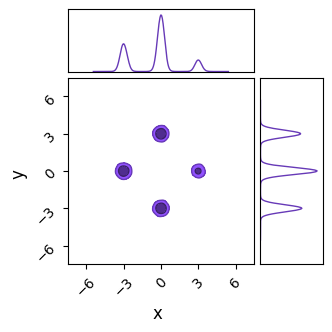

In [10]:
output_NS = NS.get_samples(jax.random.PRNGKey(1), num_samples = nsamples*nchains)
do_plot(output_NS, name = "NS", do_paths=False, color = 'purple')

-----
## Rough / Aliased Geometry <a id='roughdist'></a>

In the previous example, we only considered  the simple case of a 'smooth' posterior, where nothing unfriendly is happening aside from multimodality and HMC returns results that are a bit skewed, but not entirely unreasonable. However, HMC can fail entirely if the inter-modal 'flat' space isn't flat: its leveraging of gradients makes it extremely susceptible to getting pinned against any features of 'roughness' in the likelihood function. In this example, we'll build another toy version of this problem and show how quickly our toolset falls over with only a minor change. 

Like before, we'll create a potential function and send it to NumPyro, but this time adding a semi-regular 'noise':

In [11]:
def bad_potential(x,y):
    return potential(x,y) + (jnp.exp(jnp.sin(10*x)/2) * jnp.exp(jnp.sin(10*y)/8) -0.5) * 1E-4

def bad_model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(xmin,xmax))
    y = numpyro.sample('y', numpyro.distributions.Uniform(ymin,ymax))
    
    numpyro.factor('potfunc',jnp.log(bad_potential(x,y) + 1E-14))

This 'noise' is very low contrast: the peaks and valleys it forms are not even visible when looking at the non-likelihood, but they are still very much present in the _log_ likelihood which many MCMC methods actually navigate by.

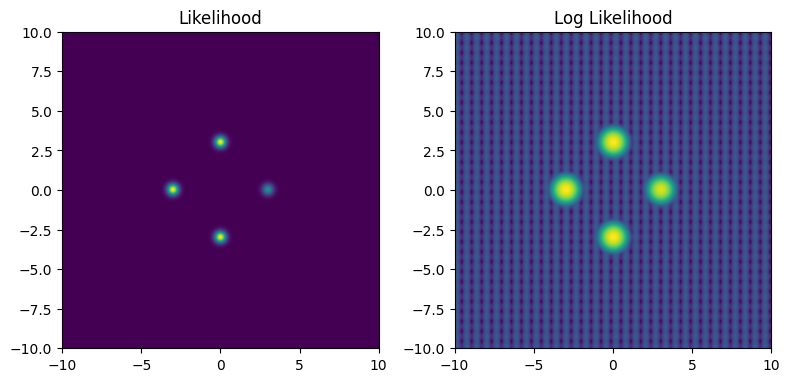

In [12]:
# Generate a grid of X/Y values
nplot = 1024
xplot, yplot = jnp.linspace(xmin,xmax, nplot), jnp.linspace(ymin,ymax, nplot)
X, Y = jnp.meshgrid(xplot, yplot)
Z2 = bad_potential(X,Y)

#---------------
# Plotting
fig_grid, ax_grid = plt.subplots(1,2, figsize=(8,4))
ax_grid[0].imshow(Z2[::-1,::], extent = [xmin, xmax, ymin, ymax])
ax_grid[1].imshow(np.log(Z2[::-1,::]), extent = [xmin, xmax, ymin, ymax])

ax_grid[0].set_title("Likelihood")
ax_grid[1].set_title("Log Likelihood")

fig_grid.tight_layout()


This may seem like an unimportant change, but the real danger doesn't come from the ridges of _increased_ likelihood, but rather the low-likelihood gaps between them. These form "walls" of negative potential energy, which HMC's gradient based navigation bounces right off.

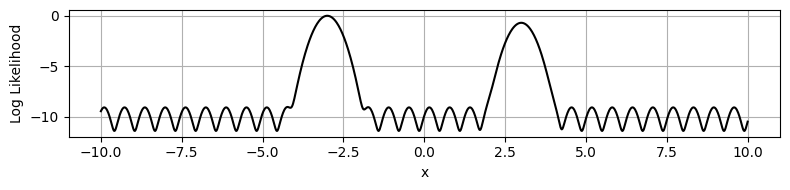

In [13]:
plt.figure(figsize=(8,2))
plt.plot(xplot, np.log(Z2[nplot//2,::]), c='k')
plt.ylabel('Log Likelihood')
plt.xlabel('x')
plt.tight_layout()
plt.grid()
plt.show()

 If we try running HMC on this distribution...

In [14]:
nchains  = 300
nsamples = 100
nburn    = 200
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(bad_model),
    num_warmup  = nburn,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_HMC_rough=sampler.get_samples()

Starting Sampling...
Sampling Done


We see that it fails to converge, especially along the $x$ axis where the "noise" is worse. The chains cannot navigate past the 'walls' of noise in any reasonable amount of burn-in time, and so we get a muddy mess contaminated by chains that are stuck in "valleys" of local optima.

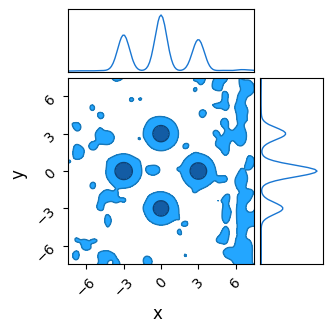

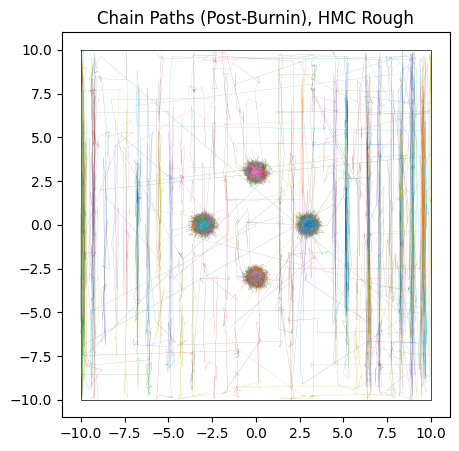

In [15]:
do_plot(output_HMC_rough, "HMC Rough", color = 'blue')

This "noise" might seem like a contrived problem, but it's surprisingly common in any case where a parameter lives in the same "domain" as discretely sampled data. For example, fitting a gaussian density to spatially binned data, inferring the delay between two time-series' and spectral decomposition all have similar versions of this "aliasing" problem, even (and sometimes especially) when their data is good. 

### Barker Metropolis-Hastings & Sample Adaptive
HMC falls flat on its face in "aliased" problems, but how do its non kinematic cousins Barker-MH and Sample Adaptive fair?

Testing BMH first, we see that it does slightly better than HMC: it's Metropolis-Hastings style "jumping" means that it can "tunnel-through" the potential walls to navigate a bit easier. The result is more chains convering on the "true" modes and less stuck in flat-space, though with the underlying issues of multimodality still rearing their head.

Starting Sampling...


Sampling Done


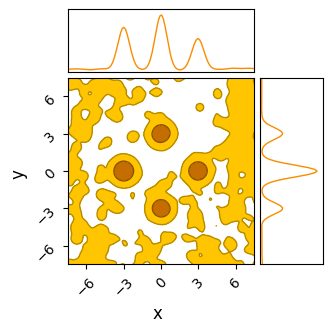

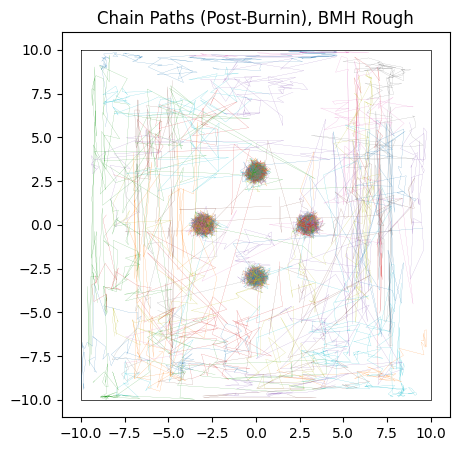

In [16]:
# Barker MH
sampler = numpyro.infer.MCMC(
    numpyro.infer.BarkerMH(bad_model),
    num_warmup  = 300,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_BMH_rough=sampler.get_samples()
do_plot(output_BMH_rough, "BMH Rough", color = 'orange')

Sample adaptive, which is _entirely_ gradient free, fairs a little better. Though it still has trouble crossing the flat regions, as evidenced by many of its samples still being far from the "islands" of likelihood, its crude covariance based gaussian sampling actually renders it far less susceptible to the noise. SA gets its strength not from cleverly navigating each individual chain, but by combining information from the entire ensemble. Even if one chain is stuck in the mud, the ensemble at large still has ways to progress.

In this particular realization, SA has actually done a decent job of handling the multi-modality by sheer chance. As when the noise was absent, SA would _eventually_ converge to the true distribution by a sheer volume samples overwhelming its slow mixing, but at that point we have to ask if a crude grid-search would be better.

Starting Sampling...


Sampling Done


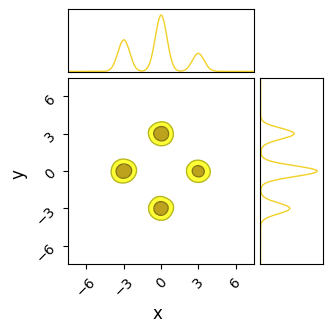

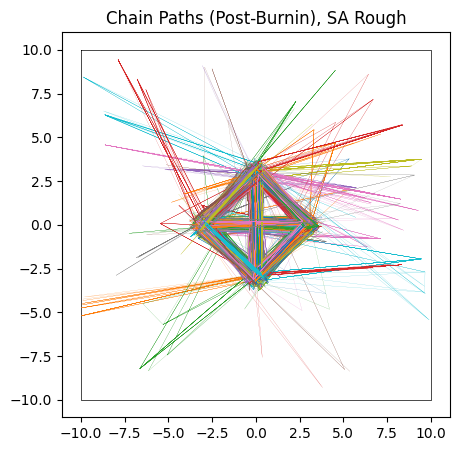

In [17]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.SA(bad_model),
    num_warmup  = 4000,
    num_samples = nsamples,
    num_chains  = nchains,
    progress_bar= False,
    chain_method = 'sequential',
)
print("Starting Sampling...")
sampler.run(jax.random.PRNGKey(0))
print("Sampling Done")
output_SA_rough=sampler.get_samples()
do_plot(output_SA_rough, "SA Rough", color = 'yellow')

### Nested Sampling
Fortunately, we nested sampling performs much better in  these cases. Much like SA, it navigates by combining information about the entire ensemble of samples rather than just local information; once a few live points congregate at the islands of high likelihood, NS is unaffected by the noise.

However, NS isn't completely immune to the aliasing noise: in this example I've had to _triple_ the number of live points compared to the noise-free case to get good results and run the entire chain much longer for it to converge. Even with this change, NS is still producing peaks that are aritifically broad. Speaking generally, you can handle _most_ problems by throwing enough live points at it, but you should keep in mind that NS isn't a silver bullet for all multimodal problems.

Starting Sampling


Sampling Done


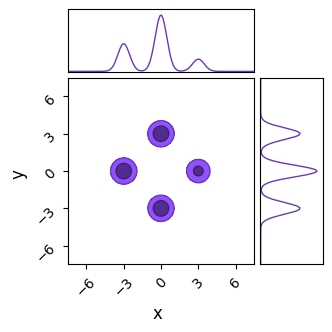

In [48]:
from numpyro.contrib.nested_sampling import NestedSampler

nlive_rough = nlive * 3
maxsamples_rough = nlive_rough * 5

NS = NestedSampler(bad_model, constructor_kwargs={"num_live_points" : nlive_rough, "max_samples": maxsamples_rough})
print("Starting Sampling")
NS.run(jax.random.PRNGKey(1))
print("Sampling Done")

output_NS_rough = NS.get_samples(jax.random.PRNGKey(1), num_samples = nsamples*nchains)
do_plot(output_NS_rough, name = "NS", do_paths=False, color = 'purple')